# Bayesian Quantum Feedback Simulations

see https://arxiv.org/abs/cond-mat/0507011

In [2]:
import numpy as np
from math import *
import matplotlib.pyplot as plt
import ipywidgets as widgets
from scipy.integrate import odeint
%matplotlib notebook

## Code

In [3]:
def SRK2(f,g,r0,tvals,nstrength = 1):
    
    '''
    Second order stochastic Runge-Kutta algorithm for integration of stochastic differential equations in Ito form:
    dr = f(r,t)*dt + g(r,t)*dW. (Modified for Bayesian equations).

    f: [Function taking and returning numpy arrays] Drift term of form f(r,t)
    g: [Function taking and returning numpy arrays] Diffusion term of form g(r,t)
    r0: [Array] Initial conditions
    tvals: [Array] Time values for which to obtain solution

    RETURNS: Solution matrix.
    '''

    r0 = np.array(r0)
    out = np.zeros((len(tvals),len(r0)))
    out[0] = r0
    
    for i in range(0,len(tvals) - 1, 1):
        dt = tvals[i + 1] - tvals[i]
        #dW = nstrength*np.random.normal(scale = np.sqrt(dt), size = len(r0))
        dW = nstrength*np.random.normal(scale = np.sqrt(dt), size = 1)
        
        rn = out[i]
        tn = tvals[i]
        
        
        rn_b = rn + np.multiply(f(rn,tn),dt)+ g(rn,tn)*dW
        rn_p = rn + np.multiply(f(rn,tn),dt) + g(rn,tn)*np.sqrt(dt)
        rn_m = rn + np.multiply(f(rn,tn),dt) - g(rn,tn)*np.sqrt(dt)
        
        tmp = np.add(f(rn_b,tn),f(rn,tn))
        
        term1 = (1/2)*np.multiply(tmp,dt)
        term2 = (1/4)*(g(rn_p,tn) + g(rn_b,tn) + 2*g(rn,tn))*dW
        term3 = (1/4)*(g(rn_p,tn) - g(rn_m,tn))*(dW**2 - dt)*(1/dt)**(1/2)
        
        out[i + 1] = rn + term1 + term2 + term3 
        
    return out

def f_bayQB(r,t,om=0,delI=0,SI=1,eps=1,gam=0):

    '''
    Deterministic Drift for Bayesian equations of motion of a Qubit with quantum point contact
    like measurement device in Ito form: (32)-(33) Korotkov 2000,
    https://arxiv.org/pdf/cond-mat/0008461.pdf.
    
    eps: [Float] Mixing Strength
    delI: [Float] Differenence between average current of detector when QB is in Up or down state.
    SI: [Float] Spectral density of current noise.
    om: [Float] Energy asymmettry. 
    gam: [Float] Dephasing rate.
    
    r[0]:p11, r[1]:p22, r[2]:p12.real ,r[3]:p12.imag
    '''
    
    tmp1 = - eps*r[3]
    tmp2 = 1j*om*(r[2]+1j*r[3]) + 1j*(eps/2)*(r[0] - r[1]) - (gam + (delI**2)/(4*SI))*(r[2]+1j*r[3]) 
    
    return np.array([tmp1,-tmp1,tmp2.real,tmp2.imag])

def g_bayQB(r,t,om=0,delI=0,SI=1,eps=1,gam=0):

    '''
    Noise term for Bayesian equations of motion of a Qubit with quantum point contact
    like measurement device in Ito form: (32)-(33) Korotkov 2000,
    https://arxiv.org/pdf/cond-mat/0008461.pdf.
    
    eps: [Float] Mixing Strength
    delI: [Float] Differenence between average current of detector when QB is in Up or down state.
    SI: [Float] Spectral density of current noise.
    om: [Float] Energy asymmettry. 
    gam: [Float] Dephasing rate.
    
    r[0]:p11, r[1]:p22, r[2]:p12.real ,r[3]:p12.imag
    '''
    
    tmp1 = 2*r[0]*r[1]*(delI/SI)
    tmp2 = - (r[0] - r[1])*(delI/SI)*(r[2]+1j*r[3])
    
    return np.array([tmp1,-tmp1,tmp2.real,tmp2.imag])

## Feedback loop

In [4]:
def f_bayQBfb(r,t,om=0,delI=0,SI=1,eps=1,gam=0,F=1):

    '''
    Deterministic Drift for Bayesian feedback control system (Korotkov). IGNORE NOT YET WORKING 
    
    F: [Float] Freedback Strength
    H: [Float] Mixing Strength
    delI: [Float] Difference between average current of detector when QB is in up or down state.
    SI: [Float] Spectral density of current noise.
    eps: [Float] Energy asymmettry. 
    gam: [Float] Dephasing rate.
    
    r[0]:p11, r[1]:p22, r[2]:p12.real ,r[3]:p12.imag
    '''
    # Control law for delta H
    def deleps(r,t):
        Om = 1
        if abs(r[0] - r[1]) > 0.00001:
            phi = (np.arctan((2*r[3])/(r[0] - r[1])) + (pi/2)*(1 + np.sign(r[0] - r[1])))%(2*np.pi)
            delphi = phi - (Om*t)%(2*pi)  
            return -F*(eps/2)*delphi
        else:
            return 0
    
    tmp1 = -(eps+deleps(r,t))*r[3]
    tmp2 = 1j*om*(r[2]+1j*r[3]) + 1j*((eps+deleps(r,t))/2)*(r[0] - r[1]) - (gam + (delI**2)/(4*SI))*(r[2]+1j*r[3]) 
    
    return np.array([tmp1,-tmp1,tmp2.real,tmp2.imag])

In [5]:
def f_bayQBfba(r,t,om=0,delI=0,SI=1,eps=1,gam=0,F=1, theta0 =0):

    '''
    Deterministic Drift for Bayesian feedback control system (Own attempt 1). For symmetric Qubit.
    
    F: [Float] Freedback Strength
    H: [Float] Mixing Strength
    delI: [Float] Difference between average current of detector when QB is in up or down state.
    SI: [Float] Spectral density of current noise.
    eps: [Float] Energy asymmettry. 
    gam: [Float] Dephasing rate.
    
    
    r[0]:p11, r[1]:p22, r[2]:p12.real ,r[3]:p12.imag
    '''
    
    # Control law for delta eps
    
    Om = 1
    '''
    def theta(r=r,t=t):
        if abs(r[0] - r[1]) > 10**(-13):
            # theta = arctan(y/z)
            return np.arctan((2*r[3])/(r[0] - r[1]))
        else:
            return 0
    '''

    def theta(r=r,t=t):
        if abs(r[0] - r[1]) > 10**(-13):
            return  (np.arctan((2*r[3])/(r[0] - r[1])) + (np.pi/2)*(1 - np.sign(r[0]-r[1])))%(2*np.pi)
        else:
            return 0
        
    def thetad(r=r,t=t):
        '''
        Desired value for theta.
        '''
        return (theta0 + Om*t)%(2*np.pi) 
    
    def shiftto_thd(th, thd):
        '''
        Shifts zero of our axis for theta so that thetad is at origin.
        '''
        tmp = (th - thd)%(2*np.pi) 
        return tmp
    
    th_sh = shiftto_thd(th = theta(), thd = thetad())
    
    def deleps(r,t):
        if  th_sh >= np.pi:
            delth = 2*np.pi - th_sh
            return F*eps*delth
        elif th_sh < np.pi:
            delth = th_sh
            return - F*eps*delth
        
    tmp1 = -(eps+deleps(r,t))*r[3]
    tmp2 = 1j*om*(r[2]+1j*r[3]) + 1j*((eps+deleps(r,t))/2)*(r[0] - r[1]) - (gam + (delI**2)/(4*SI))*(r[2]+1j*r[3])
    
    return np.array([tmp1,-tmp1,tmp2.real,tmp2.imag])

#### Without Feedback

In [6]:
# Parameters
def fcust(r,t):
    return f_bayQBfba(r,t,om=0,delI=1,SI=1,eps=1,gam=0, F=0,theta0 = 0)
def gcust(r,t):
    return g_bayQB(r,t,om=0,delI=1,SI=1,eps=1,gam=0)
# Initial density matrix 
z = 1
r0 = np.array([0.5*(1+z),0.5*(1-z),0.0,0.0])
# Time values
tvals = np.linspace(0,10,1000)
# Simulation
traj = SRK2(fcust,gcust,r0,tvals)
# Simulation array --> Plotting array 
trajplt = np.transpose(traj)

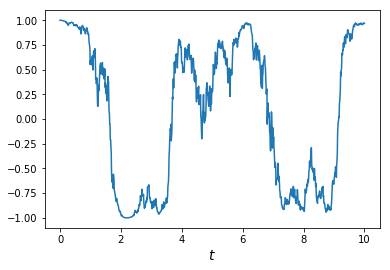

In [7]:
# Values to plot
ylist = trajplt[3]
zlist = trajplt[0] - trajplt[1]  
thlist = np.arctan(ylist/zlist)
# Plotting 
%matplotlib inline
plt.plot(tvals,zlist)
#plt.ylabel(r'$z $',fontsize=14)
plt.xlabel(r'$ t $',fontsize=14)
plt.show()

#### With Feedback

In [8]:
# Parameters
def fcust(r,t):
    return f_bayQBfba(r,t,om=0,delI=1,SI=1,eps=1,gam=0, F=10,theta0 = 0)
def gcust(r,t):
    return g_bayQB(r,t,om=0,delI=1,SI=1,eps=1,gam=0)
# Initial density matrix 
z = 1
r0 = np.array([0.5*(1+z),0.5*(1-z),0.0,0.0])
# Time values
tvals = np.linspace(0,10,1000)
# Simulation
traj = SRK2(fcust,gcust,r0,tvals)
# Simulation array --> Plotting array 
trajplt = np.transpose(traj)

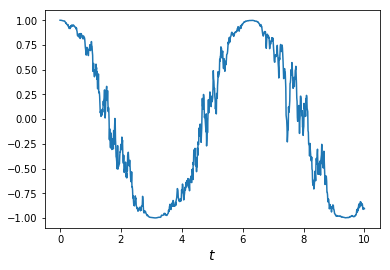

In [9]:
# Values to plot
ylist = trajplt[3]
zlist = trajplt[0] - trajplt[1]  
thlist = np.arctan(ylist/zlist)
# Plotting 
%matplotlib inline
plt.plot(tvals,zlist)
#plt.ylabel(r'$z $',fontsize=14)
plt.xlabel(r'$ t $',fontsize=14)
plt.show()

### Control diagnoser

In [10]:
def theta(r,t):
    if abs(r[0] - r[1]) < 10**(-13):
        print('zero z')
    return  (np.arctan((2*r[3])/(r[0] - r[1])) + (np.pi/2)*(1 - np.sign(r[0]-r[1])))%(2*np.pi)

def thetad(r,t,theta0 = 0,Om = 1):
    '''
    Desired value for theta.
    '''
    return (theta0 + Om*t)%(2*np.pi) 

def shiftto_thd(th, thd):
    '''
    Shifts zero of our axis for theta so that thetad is at origin.
    '''
    tmp = (th - thd)%(2*np.pi)
    return tmp

def deleps(r,t):
    F = 1
    eps = 1
    th_sh = shiftto_thd(theta(r,t),thetad(r,t))
    if  th_sh >= np.pi:
        delth = 2*np.pi - th_sh
        return F*eps*delth
    elif th_sh < np.pi:
        delth = th_sh
        return -F*eps*delth
    


In [11]:
# thetad
thlist = []
for i in range(len(traj)):
    thlist.append(theta(traj[i],tvals[i]))
    
# thetad
thdlist = []
for i in range(len(traj)):
    thdlist.append(thetad(traj[i],tvals[i]))
    
# deleps
delepslist = []
for i in range(len(traj)):
    delepslist.append(deleps(traj[i],tvals[i]))



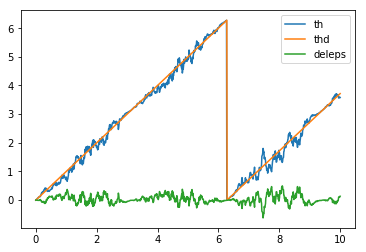

In [12]:
%matplotlib inline
plt.plot(tvals,thlist,label = 'th')
plt.plot(tvals,thdlist,label = 'thd')
plt.plot(tvals,delepslist,label = 'deleps')
plt.legend()
plt.show()